In [1]:
import sys,tweepy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.corpus import words
#nltk.download('stopwords')
#nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

c:\users\winni\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\winni\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\users\winni\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#Authentication
def twitter_auth():
    try:
        consumer_key = '---'
        consumer_secret = '---'
        access_token = '---'
        access_secret = '---'
    except KeyError:
        sys.stderr.write("Enviornment variable not set\n")
        sys.exit(1)
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth

def get_twitter_client():
    auth = twitter_auth()
    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

#Get tweets from user since May 1st
def processTweets():
    user = "BarackObama"
    api = get_twitter_client()
    status = tweepy.Cursor(api.user_timeline, id = user, tweet_mode = "extended", lang = 'en', exclude_replies = True, include_rts = False).items(10)

    tweet_list = [tweets.full_text for tweets in status]
    word_list = []
    for tweet in tweet_list:
        for word in tweet.split():
            if word.isalpha():
                word_list.append(word)
    group_words = []
    split_words = np.array_split(word_list, 10)
    for group in split_words:
        group_words.append(' '.join(group))

    return group_words

In [3]:
def tokenizer(keyword):
    return [word for word in keyword.split(' ') if (word in words.words())]

In [14]:
keywords = processTweets()
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords.words('english'), norm='l2') #Term frequency - inverse document frequency
#X = pd.DataFrame(tfidf.fit_transform(keywords).toarray(), index=keywords, columns=tfidf.get_feature_names())
#print(X) #Display each feature with tfidf of each keyword
features = tfidf.fit_transform(keywords) #Learn vocab and idf

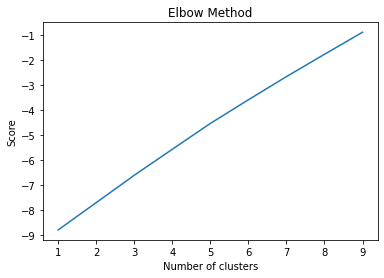

In [15]:
#Determine best value for k
opt_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i,max_iter=200) for i in opt_cluster]
score = [kmeans[i].fit(features).score(features) for i in range(len(kmeans))]
plt.plot(opt_cluster, score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [ ]:
#K-Means Clustering
k = 5
model = KMeans(n_clusters=k, init='k-means++', n_init=2, max_iter=100)
kmeans = model.fit(features)
prediction = kmeans.predict(features)

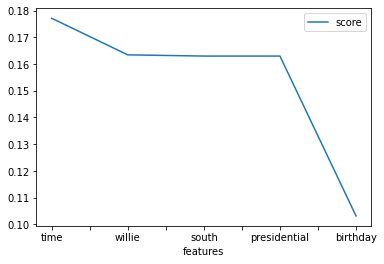

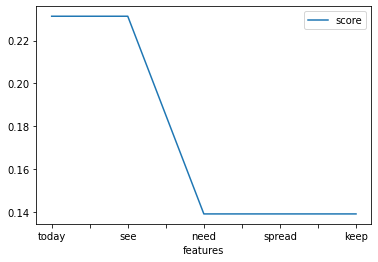

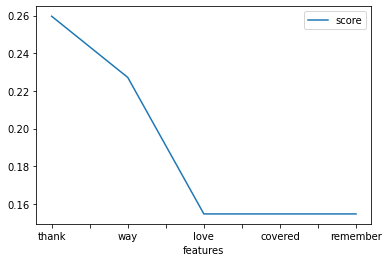

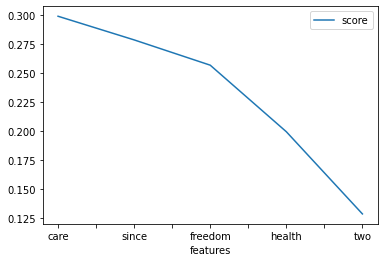

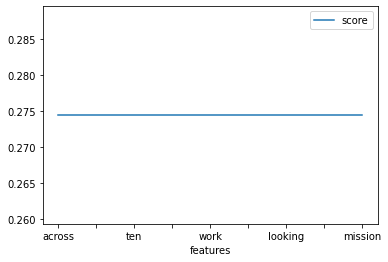

In [27]:
#Top 5 terms with best score from each cluster
terms = tfidf.get_feature_names()
labels = np.unique(prediction)
tfidf_array = features.toarray()
for label in labels:
    index = np.where(prediction == label)
    means = np.mean(tfidf_array[index], axis = 0)#average score for each cluster
    sorted_mean = np.argsort(means)[::-1][:5]#top 5 scores
    best_terms = [(terms[i], means[i]) for i in sorted_mean]
    graph = pd.DataFrame(best_terms,columns=['features','score'])
    graph.plot(x='features', y='score', kind='line')
    plt.show()
    

In [26]:
#Print clusters
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(k):
    print("cluster ID %d: " % i)
    for j in order_centroids[i,:]:
        print(' %s' % terms[j])
    print('--------------------------------')
    

cluster ID 0: 
 across
 ten
 work
 looking
 mission
 whose
 laden
 operation
 possible
 grateful
 reflect
 bin
 made
 people
 bo
 bravely
 good
 bill
 best
 great
 bad
 happy
 health
 around
 hope
 hopeful
 international
 keep
 always
 affordable
 led
 like
 listen
 longer
 admiral
 lost
 going
 glad
 giving
 close
 build
 care
 carried
 birthday
 catching
 celebrate
 center
 challenge
 chance
 covered
 getting
 day
 encouraging
 everyday
 expansion
 love
 freedom
 friend
 game
 gentle
 family
 young
 loyal
 make
 spending
 spirit
 spoke
 spread
 still
 story
 sure
 take
 talking
 thank
 three
 time
 today
 true
 two
 us
 vaccination
 vaccine
 visit
 way
 white
 willie
 word
 special
 south
 site
 opportunity
 many
 world
 medical
 might
 million
 moment
 month
 much
 need
 never
 place
 since
 presence
 presidential
 remember
 reminder
 rescue
 see
 segregation
 set
 shore
 sign
 mark
--------------------------------
cluster ID 1: 
 getting
 today
 see
 vaccine
 world
 medical
 celebr